In [21]:
import os
import cv2
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *

In [2]:
os.makedirs("dataset/labels")
os.makedirs("dataset/images")
os.makedirs("dataset/masks")

In [3]:
images = os.listdir("../input/comofod/CoMoFoD_small_v2/")
print("Total image found: {}".format(len(images)))

Total image found: 10402


In [4]:
for image in tqdm(images):
    if len(image.split("_")) == 2:
        if "B" in image:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/labels/".format(image))
    if len(image.split("_")) == 2:
        if "M" in image:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/masks/".format(image))
    if len(image.split("_")) > 2:
        if "F" in image:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/images/".format(image))
    if len(image.split("_")) > 2:
        if "O" in image:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/images/".format(image))

100%|██████████| 10402/10402 [02:10<00:00, 79.60it/s]


In [5]:
print("Total Labels: ", len(os.listdir("dataset/labels/")))
print("Total Masks: ", len(os.listdir("dataset/masks/")))
print("Total Forged Images: ", len(os.listdir("dataset/images/")))

Total Labels:  200
Total Masks:  200
Total Forged Images:  9600


In [6]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)

    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    up9 = BatchNormalization()(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

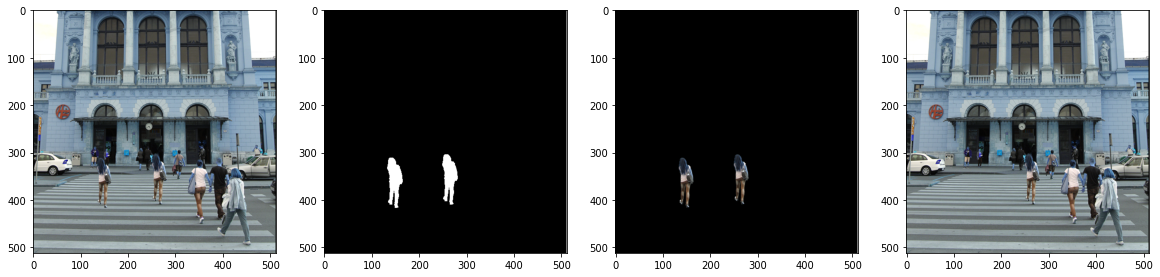

In [7]:
image = cv2.imread("dataset/images/001_F_BC1.png", cv2.IMREAD_COLOR)
mask = cv2.imread("dataset/labels/001_B.png")
cropped_image = cv2.imread("dataset/masks/001_M.png")
auth_image = cv2.imread("dataset/images/001_O_BC1.png")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 20))
ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(cropped_image)
ax4.imshow(auth_image)


In [8]:
train_test_images = os.listdir("dataset/images")
train_images = train_test_images[:int(0.9 * len(train_test_images))]
test_images = train_test_images[int(0.9 * len(train_test_images)):]

print("Training Images: {}".format(len(train_images)))
print("Testing Images: {}".format(len(test_images)))

Training Images: 8640
Testing Images: 960


In [9]:
def adjust_data(image, mask):
    image = image / 255
    mask = mask / 255
    
    return image, mask

def iou(pred, gt):
    pred = np.asarray(pred)
    gt = np.asarray(gt)
    intersection = np.logical_and(pred, gt)
    union = np.logical_or(pred, gt)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


class DataLoader(Sequence):
    
    def __init__(self, dataset_list,
                batch_size):
        self.dataset_list = dataset_list
        self.batch_size = batch_size
        np.random.shuffle(self.dataset_list)
        
    def on_epoch_end(self):
        pass
        
    def __len__(self):
        return len(self.dataset_list) // self.batch_size
        
    def __getitem__(self, index):
        i = index * self.batch_size
        batch_input_data = self.dataset_list[i : i + self.batch_size]
        x = np.zeros((self.batch_size, 256, 256, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, 256, 256, 1), dtype=np.float32)
        for j, image_name in enumerate(batch_input_data):
            image = cv2.imread("dataset/images/{}".format(image_name))
            if "O" not in image_name:
                mask = cv2.imread("dataset/labels/{}_B.png".format(image_name.split("_")[0]), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (256, 256))
                mask = np.reshape(mask, (256, 256, 1))
            else:
                mask = np.zeros((256, 256, 1), dtype=np.float32)
            image = cv2.resize(image, (256, 256))
            x[j] = image
            y[j] = mask       
            
        return adjust_data(x,y)

In [10]:
train_datagen = DataLoader(train_images, 64)
model = unet()
model_checkpoint = ModelCheckpoint('unet.h5', monitor="loss", verbose=1, save_best_only=True)

In [24]:
history = model.fit_generator(train_datagen, epochs=40, callbacks=[model_checkpoint], verbose=1)

Epoch 1/20
135/135 [==============================] - 98s 724ms/step - loss: 0.2481 - accuracy: 0.9917

Epoch 00001: loss improved from 0.26121 to 0.24806, saving model to unet.hdf5
Epoch 2/20
135/135 [==============================] - 98s 722ms/step - loss: 0.2357 - accuracy: 0.9919

Epoch 00002: loss improved from 0.24806 to 0.23573, saving model to unet.hdf5
Epoch 3/20
135/135 [==============================] - 95s 703ms/step - loss: 0.2238 - accuracy: 0.9921

Epoch 00003: loss improved from 0.23573 to 0.22384, saving model to unet.hdf5
Epoch 4/20
135/135 [==============================] - 97s 714ms/step - loss: 0.2124 - accuracy: 0.9925

Epoch 00004: loss improved from 0.22384 to 0.21241, saving model to unet.hdf5
Epoch 5/20
135/135 [==============================] - 98s 722ms/step - loss: 0.2018 - accuracy: 0.9926

Epoch 00005: loss improved from 0.21241 to 0.20181, saving model to unet.hdf5
Epoch 6/20
135/135 [==============================] - 98s 724ms/step - loss: 0.1918 - accu

In [37]:
test_datagen = DataLoader(test_images, 64)
result = model.predict(test_datagen, verbose=1)

960
15/15 [==============================] - 9s 600ms/step


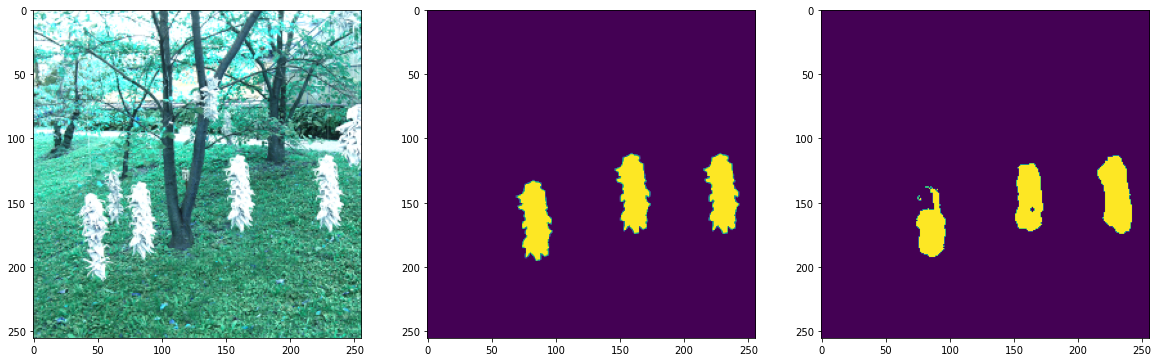

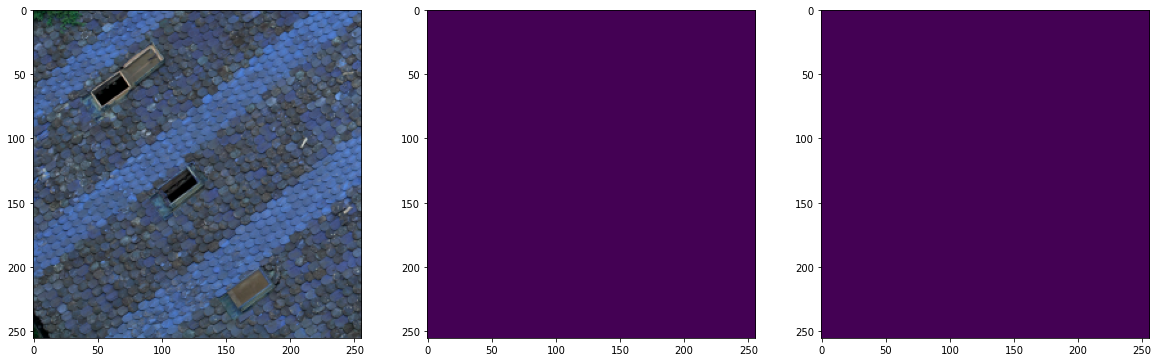

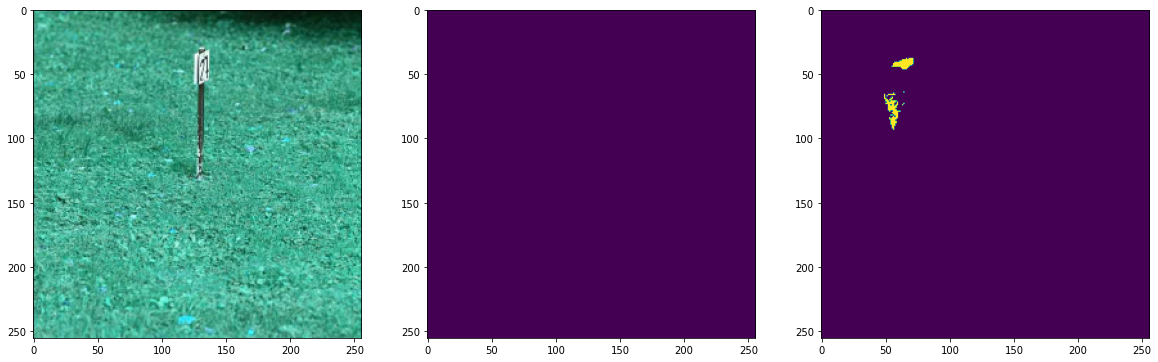

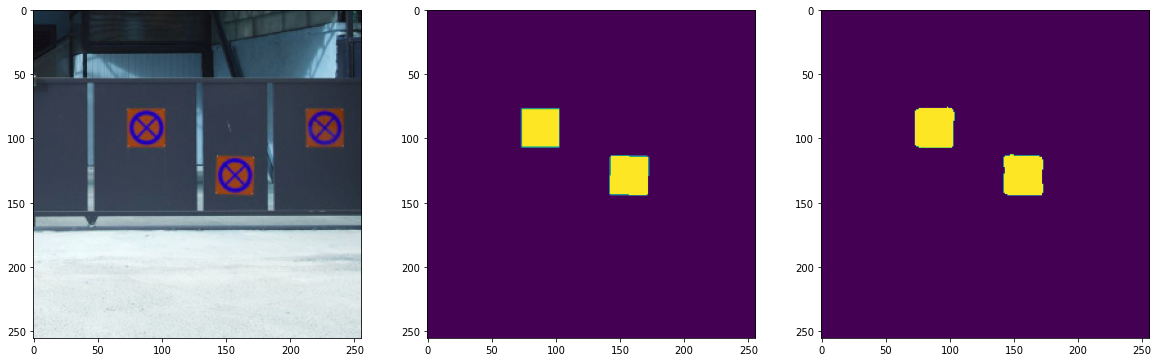

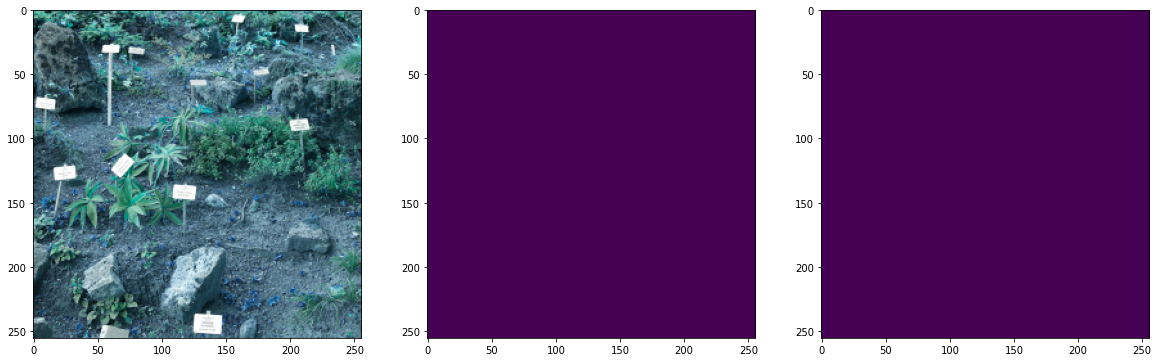

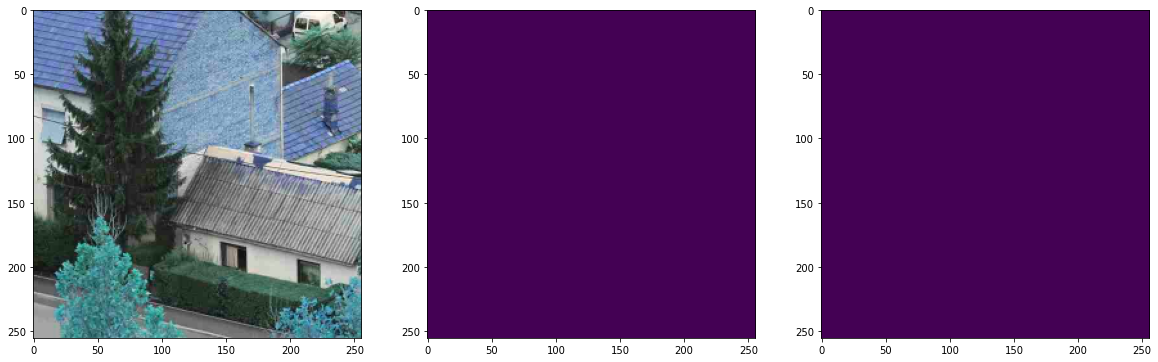

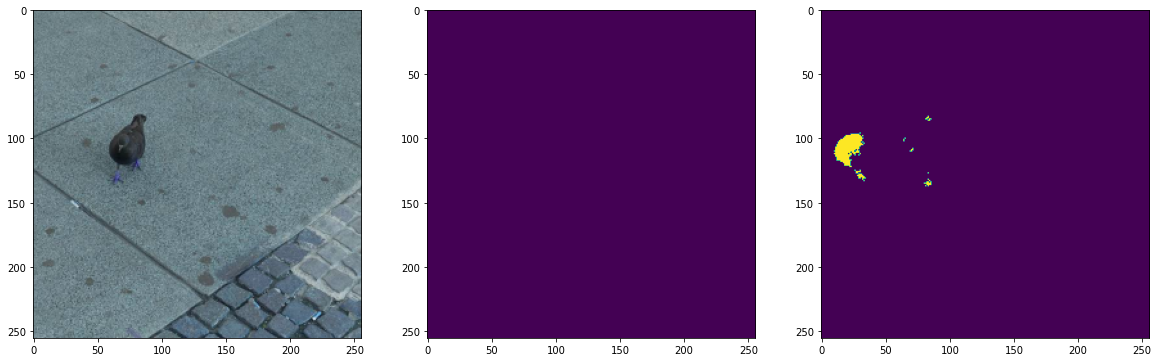

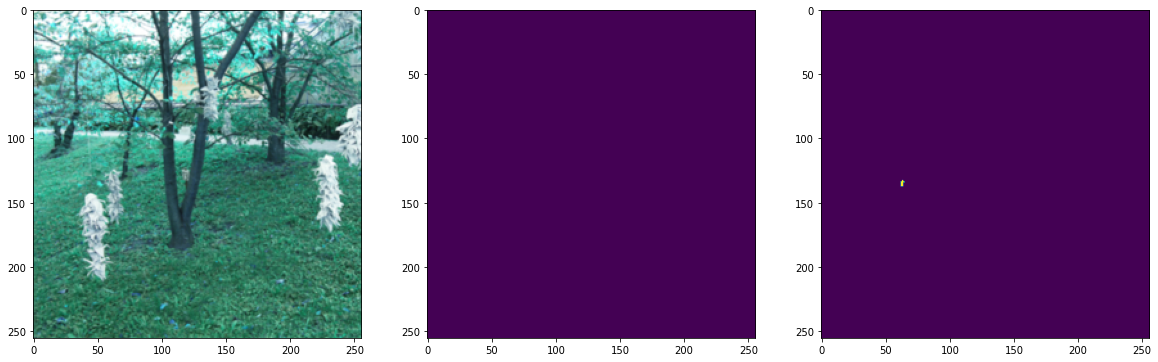

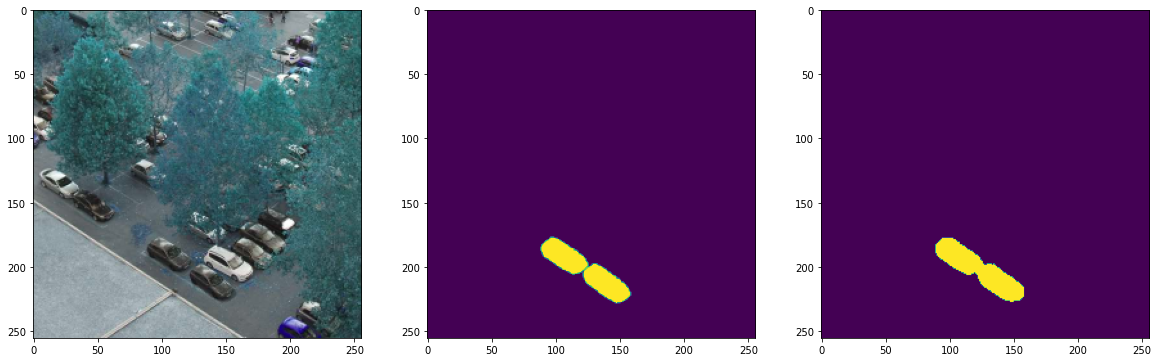

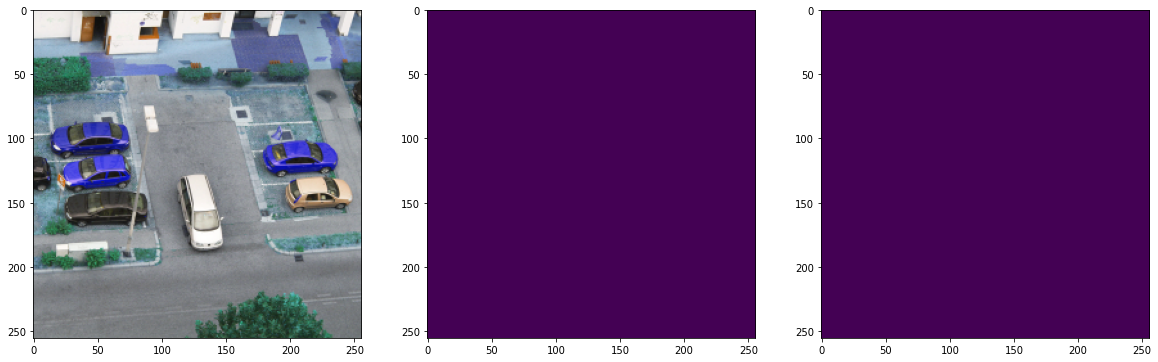

In [38]:
for i, res in enumerate(result[50:60]):
    image_name = test_images[i + 50]
    image = cv2.imread("dataset/images/{}".format(image_name), cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    if "O" not in image_name:
        mask = cv2.imread("dataset/labels/{}_B.png".format(image_name.split("_")[0]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
    else:
        mask = np.zeros((256, 256, 1), dtype=np.float32)
    
    res[res>0.5] = 1
    res[res<0.5] = 0
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
    ax1.imshow(image)
    ax2.imshow(mask)
    ax3.imshow(res)

In [39]:
iou = []
mean_iou = 0
for i, res in enumerate(result):
    image_name = test_images[i]
    if "O" not in image_name:
        mask = cv2.imread("dataset/labels/{}_B.png".format(image_name.split("_")[0]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
    else:
        mask = np.zeros((256, 256, 1), dtype=np.float32)
    res[res>0.5] = 1
    res[res<0.5] = 0
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(res, mask/255)
    mean_iou = mean_iou + m.result().numpy()
    iou.append(m.result().numpy())

In [43]:
print("Accuracy of model:", mean_iou/len(result)*100)

Accuracy of model: 76.81683645583689
